In [1]:
import pandas as pd
import scanpy as sc
import loompy as lp
import zlib
import json
import base64

In [2]:
df_meta = pd.read_csv('../../processed_data/clean_data/metadata.csv', index_col = 0)

In [5]:
id2subject = sorted(set(df_meta.subject_id))
id2label = ['Ctrl %d' % i for i in range(1, 5)] + ['Case %d' % i for i in range(1, 6)]
for s, l in zip(id2subject, id2label):
    print(s, l)

NPBB052 Ctrl 1
NPBB098 Ctrl 2
NPBB105 Ctrl 3
NPBB113 Ctrl 4
NPBB131 Case 1
NPBB135 Case 2
NPBB137 Case 3
NPBB138 Case 4
NPBB139 Case 5


In [3]:
lf = lp.connect( './output/pyscenic_aucell_output.loom', mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)
    
lf.close()

In [4]:
data_obj = sc.AnnData(auc_mtx.values, 
                     obs = df_meta,
                     var = pd.DataFrame([], index = auc_mtx.columns)
                     )

In [5]:
data_obj.var

""
ALX4(+)
ARID5B(+)
ARX(+)
ASCL1(+)
ATF3(+)
...
ZEB1(+)
ZFHX3(+)
ZIC2(+)
ZMAT4(+)


In [6]:
import matplotlib as mpl
from matplotlib import ticker
cmap = mpl.cm.Greens
import matplotlib.pyplot as plt

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
def plot_violin(data, colors, cmap, ax):
    parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

    for pc, (c, _) in zip(parts['bodies'], colors):
        pc.set_facecolor(c)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    
    quartile1, medians, quartile3 = [], [], []
    for v in data:
        q1, m, q3 = np.percentile(v, [25, 50, 75])
        quartile1 += [q1]
        medians += [m] 
        quartile3 += [q3]
        
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    #ax.pcolor([c[1] for c in colors], cmap=cmap)
    norm = mpl.colors.Normalize(vmin=min([c[1] for c in colors]), 
                                vmax=max([c[1] for c in colors]))
    
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm , cmap=cmap), pad = 0.01, ax=ax)
    
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    
    return ax




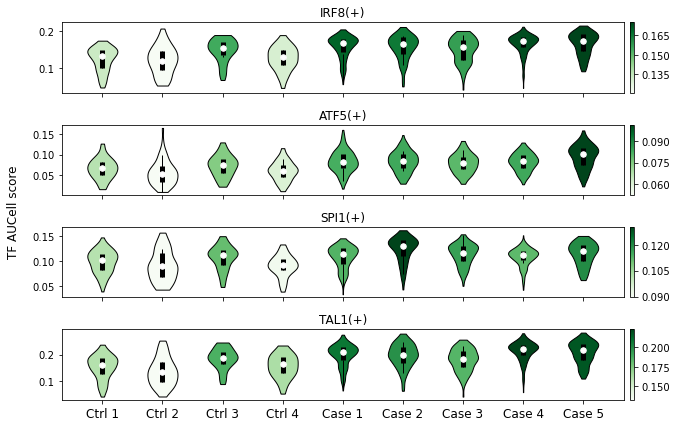

In [12]:
data_sub = data_obj[(data_obj.obs.celltype == 'Mic') & (data_obj.obs.tissue == 'PFC')]

import numpy as np

id2subject = sorted(set(df_meta.subject_id))

fig, axes = plt.subplots(4, 1, figsize = (10, 6), sharex=True)

for ic, v in enumerate(['IRF8(+)', 'ATF5(+)', 'SPI1(+)', 'TAL1(+)']):

    data = [np.squeeze(data_sub[:, v].X[data_sub.obs.subject_id == s].copy()) for s in id2subject]
    #data = [np.squeeze(vec[df_meta.subject_id == s]).copy() for s in id2subject]
    med = np.array([np.median(v) for v in data])
    med_norm = (med - med.min()) / (med.max() - med.min())
    colors = [(cmap(mn), m) for m, mn in zip(med, med_norm)]

    #colors = ['#D43F3A'] * 9
    ax = plot_violin(data, colors, cmap, axes[ic])
    ax.set_title(v.replace('_', ' '))
plt.tight_layout()
#plt.xticks([i+1 for i in range(9)], id2subject, fontsize = 12)
id2label = ['Ctrl %d' % i for i in range(1, 5)] + ['Case %d' % i for i in range(1, 6)]
plt.xticks([i+1 for i in range(9)], id2label, fontsize = 12)

fig.text(-0.02, 0.5, 'TF AUCell score', va='center', rotation='vertical', fontsize = 12)
plt.savefig('../../figs/scenic_mic_tf_scores.pdf', bbox_inches='tight')
plt.savefig('../../figs/png/scenic_mic_tf_scores.png', dpi = 600, bbox_inches='tight')
plt.show()